(250, 2)


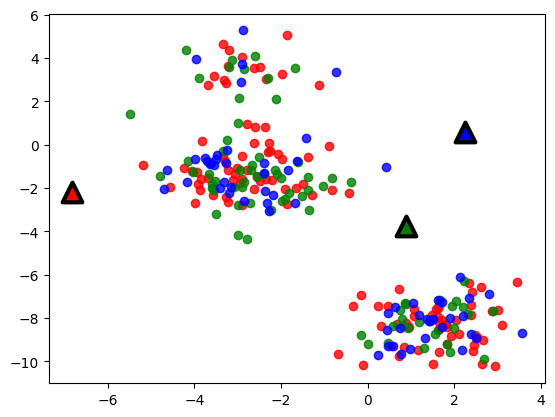

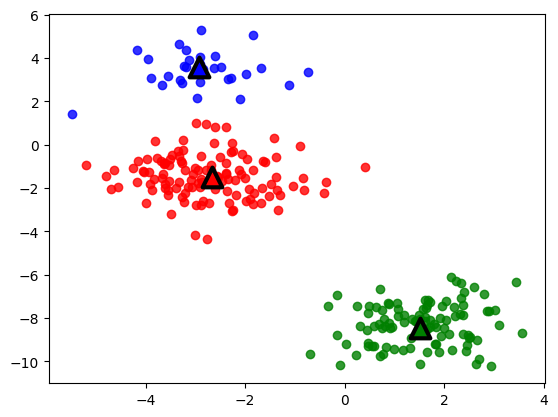

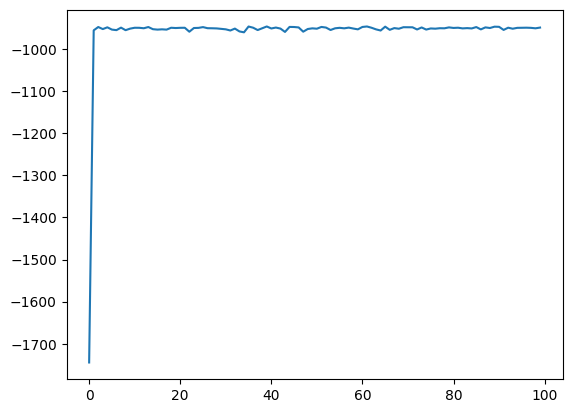

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import dirichlet, multivariate_normal


# Data.
with open("data/hw1_250.txt", "r") as f:
    x = np.array([[float(i) for i in line.split()] for line in f.read().split("\n") if line])
print(x.shape)

N = len(x)
K = 3
I2 = np.eye(2)


# Init.
ALPHA = [1, 1, 1]
# TODO: use scipy dists for everything
pi = np.random.dirichlet(alpha=ALPHA)
z = np.random.choice(a=np.arange(K), size=N, p=pi)
mu = np.random.multivariate_normal(mean=[0, 0], cov=10 * I2, size=K)

K_COLORS = ["red", "green", "blue"]
def plot_clusters(x: np.ndarray, z: np.ndarray, mu: np.ndarray) -> None:
    for k in range(K):
        mask = z == k
        plt.scatter(x[mask, 0], x[mask, 1], c=K_COLORS[k], alpha=0.8)
    for k in range(K):
        plt.scatter(mu[k, 0], mu[k, 1], c=K_COLORS[k], marker="^", s=200, linewidths=3, edgecolor="black")
    plt.show()

plot_clusters(x, z, mu)


def calc_log_likelihood(x: np.ndarray, z: np.ndarray, mu: np.ndarray, pi: np.ndarray) -> float:
    p_pi = dirichlet.logpdf(x=pi, alpha=ALPHA)
    p_mu = multivariate_normal.logpdf(mu, mean=np.array([0, 0]), cov=10).sum()
    p_z = np.log(pi)[z].sum()

    p_x = sum(multivariate_normal.logpdf(x[z == i], mean=mu[i], cov=1).sum() for i in range(K))
    return p_pi + p_mu + p_z + p_x


# Sample.
N_STEPS = 100
log_likelihoods = []
for step in range(N_STEPS):
    # z.
    dist = ((x - mu[:, None, :]) ** 2).sum(axis=-1)
    unnorm_p = pi[:, None] * np.exp(-0.5 * dist)
    p = unnorm_p / unnorm_p.sum(axis=0)

    cum_probs = np.cumsum(p, axis=0)
    rand = np.random.random(cum_probs.shape[1])
    z = (rand >= cum_probs).sum(axis=0)

    # pi
    n = (z[:, None] == np.arange(K)).sum(axis=0)
    pi = np.random.dirichlet(n + 1)

    # mu
    s = np.array([x[z == i].sum(axis=0) for i in range(K)])
    mu_new = s / (0.1 + n[:, None])
    sigma_new = I2 / (0.1 + n[:, None, None])
    mu = np.array([np.random.multivariate_normal(mean=mu_new[i], cov=sigma_new[i]) for i in range(K)])

    # calc log prob of data
    log_likelihoods.append(calc_log_likelihood(x, z, mu, pi))

plot_clusters(x, z, mu)

plt.plot(log_likelihoods)